In [1]:
!export HF_HOME=/run/media/anton/hdd/hf

/home/anton/source/torch-env/lib/python3.12/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

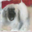

In [1]:
import os
import diffusers
import torch

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd.functional import jacobian

import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

from diffusers import DDPMPipeline, UNet2DModel

from urllib.request import urlopen 
import json 




os.environ['HF_HOME'] = "/run/media/anton/hdd/hf"

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model_id = "google/ddpm-cifar10-32"

ddpm = DDPMPipeline.from_pretrained(model_id) 
ddpm = ddpm.to(device)
image = ddpm().images[0]
image.save("ddpm_cifar10_generated.png")
image

In [2]:
random=False

if random:
    # create random unet
    unet_config_url = "https://huggingface.co/google/ddpm-cifar10-32/raw/main/config.json"
    response = urlopen(unet_config_url) 
    data_json = json.loads(response.read()) 
    unet_random = UNet2DModel(**data_json)
    
    # add to pipeline
    ddpm_random = DDPMPipeline(unet=unet_random, scheduler=ddpm.scheduler)
    ddpm = ddpm_random.to(device)

In [3]:
ddpm

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.29.1",
  "_name_or_path": "google/ddpm-cifar10-32",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [4]:
ddpm.scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.29.1",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_large"
}

In [5]:
ddpm.unet

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(12

## Sample data

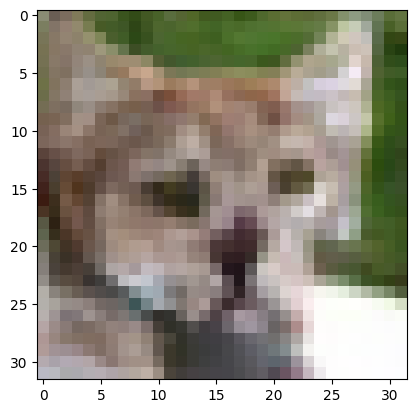

In [9]:
#cifar10 = load_dataset("uoft-cs/cifar10", split = "train", cache_dir="/run/media/anton/hdd/hf", streaming=True)
#training_data_loader = DataLoader(dataset_train, batch_size=1, shuffle=True)
#image, y = next(iter(training_data_loader))

#image = image.to(device)

from torchvision.transforms import Compose, PILToTensor, ConvertImageDtype


def transform(image):
    transform = Compose([
        PILToTensor(),
        ConvertImageDtype(torch.float)
    ])
    return transform(image)

image = transform(image)

image = image[None, :]

# image = image[0]

plt.imshow(np.moveaxis(image[0].cpu().numpy(), 0, -1))

image = image.to(device)

plt.savefig("generated.jpg", dpi=300)

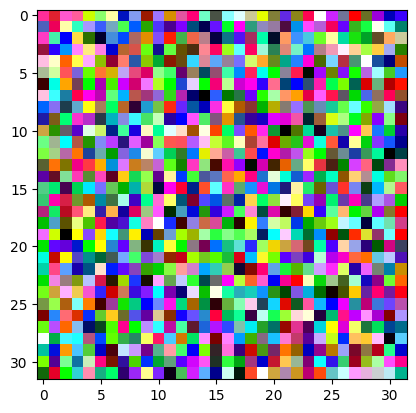

In [96]:
beta_start=1e-4
beta_end=2e-2
steps=1000
t=900

betas = torch.arange(start=beta_start, end=beta_end, step=(beta_end - beta_start)/steps)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, dim=0).to(device)

def add_noise(image, t, rescaled=False, return_beta=False):

    noise = torch.randn(image.shape).to(device)

    image_scaled = 2 * image - 1

    image_noisy = torch.sqrt(alphas_prod[t]) * image_scaled + torch.sqrt(1 - alphas_prod[t]) * noise

    if rescaled:
        image_noisy = torch.clip(image_noisy / 2 + 0.5, min=0, max=1)

    if return_beta:
        return image_noisy, betas[t]
    
    return image_noisy


image_noisy = add_noise(image=image, t=t, rescaled=True)

plt.imshow(np.moveaxis(image_noisy[0].cpu().numpy(), 0, -1))

plt.savefig(f"generated_noisy_{t}.jpg", dpi=300)

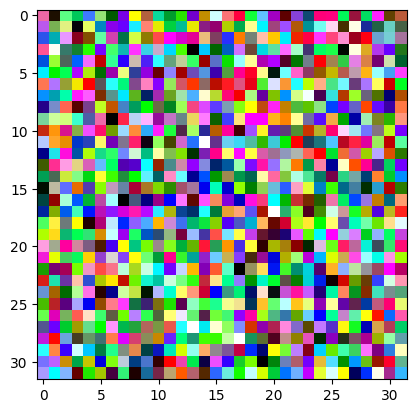

In [97]:
def denoise(image_noisy, t, rescaled=True):
    ## noisy image should be scaled [-1,1] 
    noise_pred = ddpm.unet(image_noisy, t).sample 

    mu_t = 1 / torch.sqrt(alphas[t]) * (image_noisy - (betas[t] / torch.sqrt(1 - alphas_prod[t])) * noise_pred)

    if rescaled: 
        return torch.clip(mu_t / 2 + 0.5, min=0, max=1)

    return mu_t

image_noisy = add_noise(image=image, t=t, rescaled=False)
image_denoised = denoise(image_noisy, t, rescaled=True)

plt.imshow(np.moveaxis(image_denoised[0].detach().cpu().numpy(), 0, -1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5149908..2.4666216].


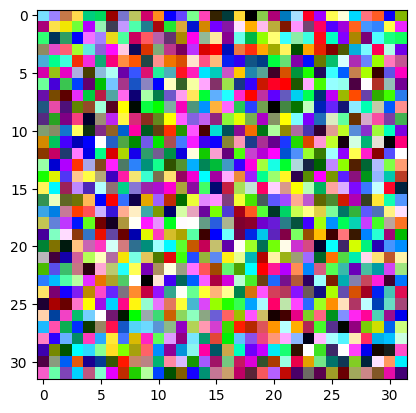

In [98]:
image_noisy = add_noise(image=image, t=t, rescaled=False)
noise_pred = ddpm.unet(image_noisy, t).sample / 2 + 0.5
plt.imshow(np.moveaxis(noise_pred[0].detach().cpu().numpy(), 0, -1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4977794..2.4493027].


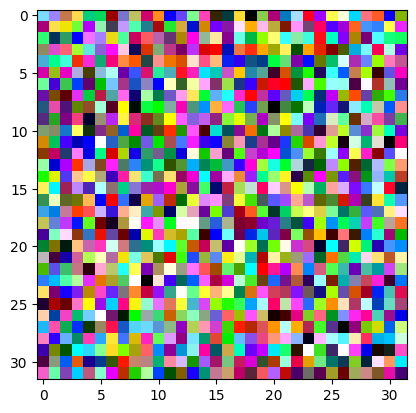

In [99]:
def noise_as_vector(x):
    x = torch.reshape(x, (1,3,32,32))
    out = ddpm.unet(x, t).sample
    return torch.reshape(out, (3072,))

def denoise_as_vector(x):
    x = torch.reshape(x, (1,3,32,32))
    pred = denoise(x, t, rescaled=False)
    return torch.reshape(pred, (3072,))

img_noisy_v = torch.reshape(image_noisy, (3072,)).to(device)

img_denoised_v = denoise_as_vector(img_noisy_v)

plt.imshow(np.moveaxis(torch.reshape(img_denoised_v / 2 + 0.5, (1,3,32,32))[0].detach().cpu().numpy(), 0, -1))

In [100]:
from torch.autograd.functional import jacobian

J_trained = jacobian(denoise_as_vector, inputs=img_noisy_v)

In [101]:
# eig = torch.linalg.eig(J_trained)
svd = torch.svd(J_trained)

In [102]:
# plt.plot(sorted(eig.eigenvalues.detach().cpu().numpy(), reverse=True))

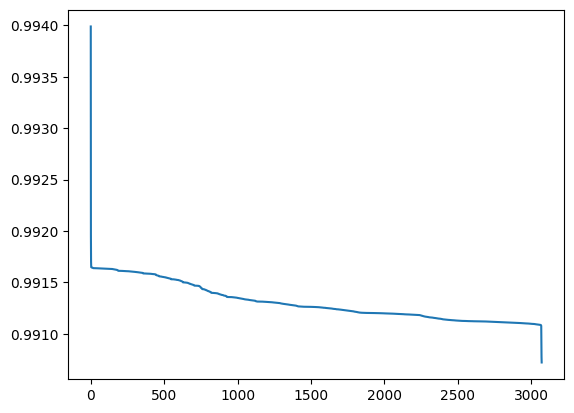

In [103]:
U = svd.U.detach().cpu().numpy()
S = svd.S.detach().cpu().numpy()
V = svd.V.detach().cpu().numpy()

plt.plot(S)

#U[0].shape

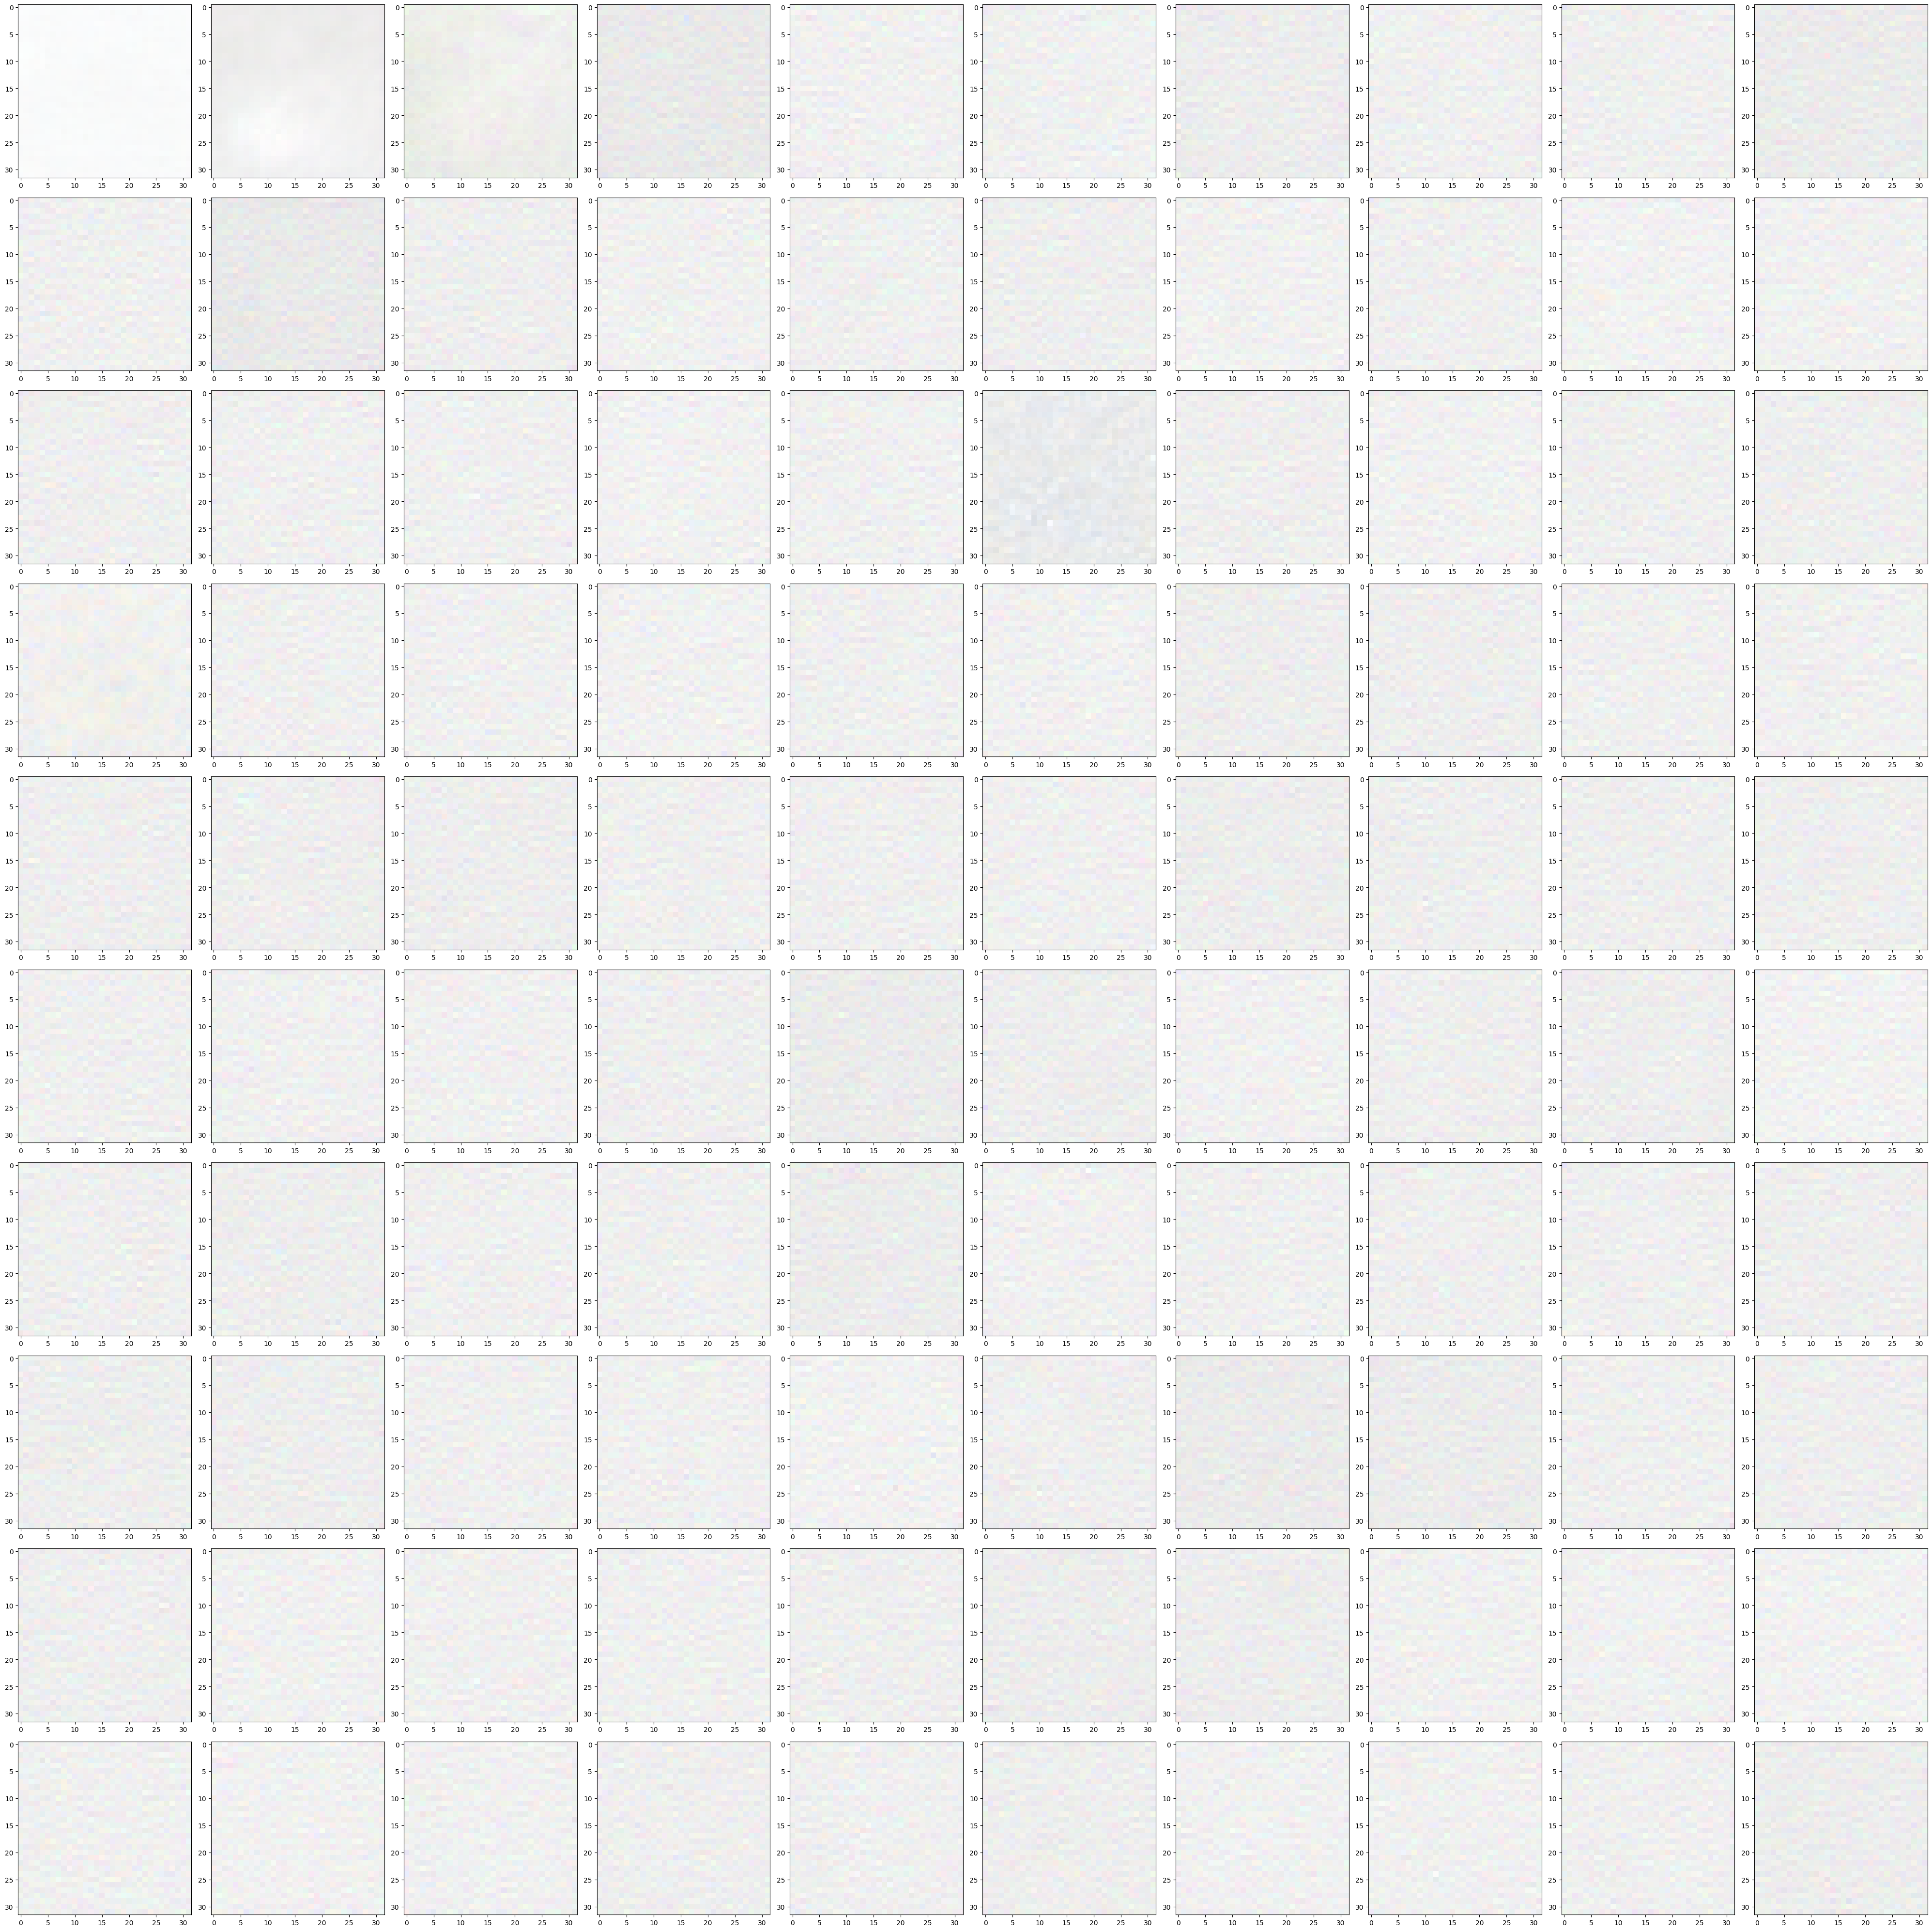

In [104]:
fig, axs = plt.subplots(10, 10, figsize=(40, 40))

axs = axs.flatten()

for j in range(100):
    top_sv = U[:, j]
    top_sv_tensor = torch.reshape(torch.tensor(top_sv), (3, 32, 32)) / 2 + 0.5
    top_sv_tensor /= torch.max(torch.abs(top_sv_tensor))
    axs[j].imshow(np.moveaxis(top_sv_tensor.numpy(), 0, -1))

plt.tight_layout()
plt.savefig(f"denoiser_top_sv_{t}.jpg",dpi=400)

In [105]:
torch.norm(J_trained - torch.diag(torch.diagonal(J_trained, 0)), p="fro")

tensor(0.0052, device='cuda:0')

In [106]:
torch.norm(svd.U @ svd.V.t(), p="fro")

tensor(55.4483, device='cuda:0')

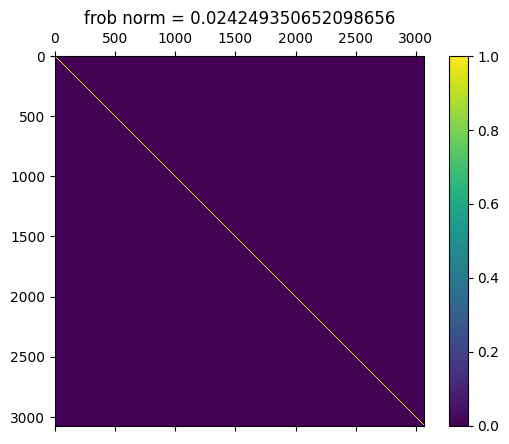

In [107]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(svd.U.cpu() @ svd.V.t().cpu(), interpolation='nearest')
fig.colorbar(cax)

ax.set_title("frob norm = " + str(torch.norm(svd.U @ svd.V.t() - torch.eye(3072).to(device), p="fro").item()))
plt.savefig(f"denoiser_diag_{t}.jpg",dpi=400)

In [108]:
torch.norm(svd.U @ svd.V.t() - torch.eye(3072).to(device), p="fro")

tensor(0.0242, device='cuda:0')

## Comparison with data

Train image similarity with dataset

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


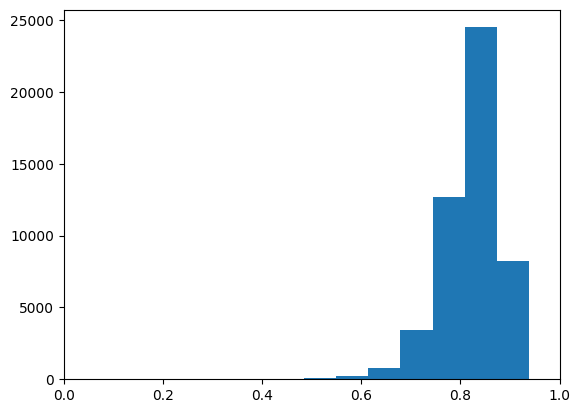

In [28]:
from datasets import load_dataset
from torchvision.transforms import Compose, PILToTensor, ConvertImageDtype

cifar10 = load_dataset("uoft-cs/cifar10", split = "train", cache_dir="/run/media/anton/hdd/hf", streaming=True)
cifar10_iterator = iter(cifar10)

def transform(image):
    transform = Compose([
        PILToTensor(),
        ConvertImageDtype(torch.float)
    ])
    return transform(image)

similarity = []

# img_generated = transform(image)
img_generated = image

for i, data in enumerate(cifar10):
    img_test = transform(data["img"]).to(device)
    
    m = torch.sum(
        (img_generated / torch.norm(img_generated)) * 
        (img_test / torch.norm(img_test))
    )
    # m = torch.norm(img_test - img_generated)
    
    similarity.append(m.detach().cpu())

    print(i) if i%1000==0 else None
    
plt.hist(similarity)
plt.xlim((0,1))

plt.savefig("cosine with CIFAR10 train")

similarity = np.array(similarity)

In [31]:
similarity_indexed = np.stack((np.arange(50000), similarity))
similarity_indexed_sorted = similarity_indexed[:, similarity_indexed[1].argsort()]

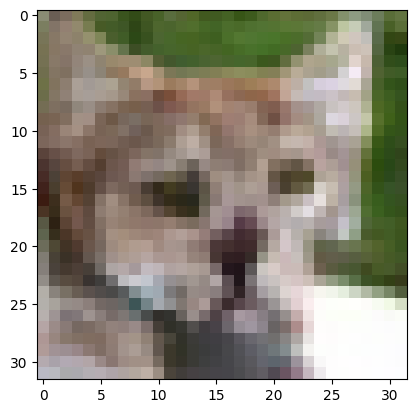

In [32]:
plt.imshow(np.moveaxis(image[0].cpu().numpy(), 0, -1))

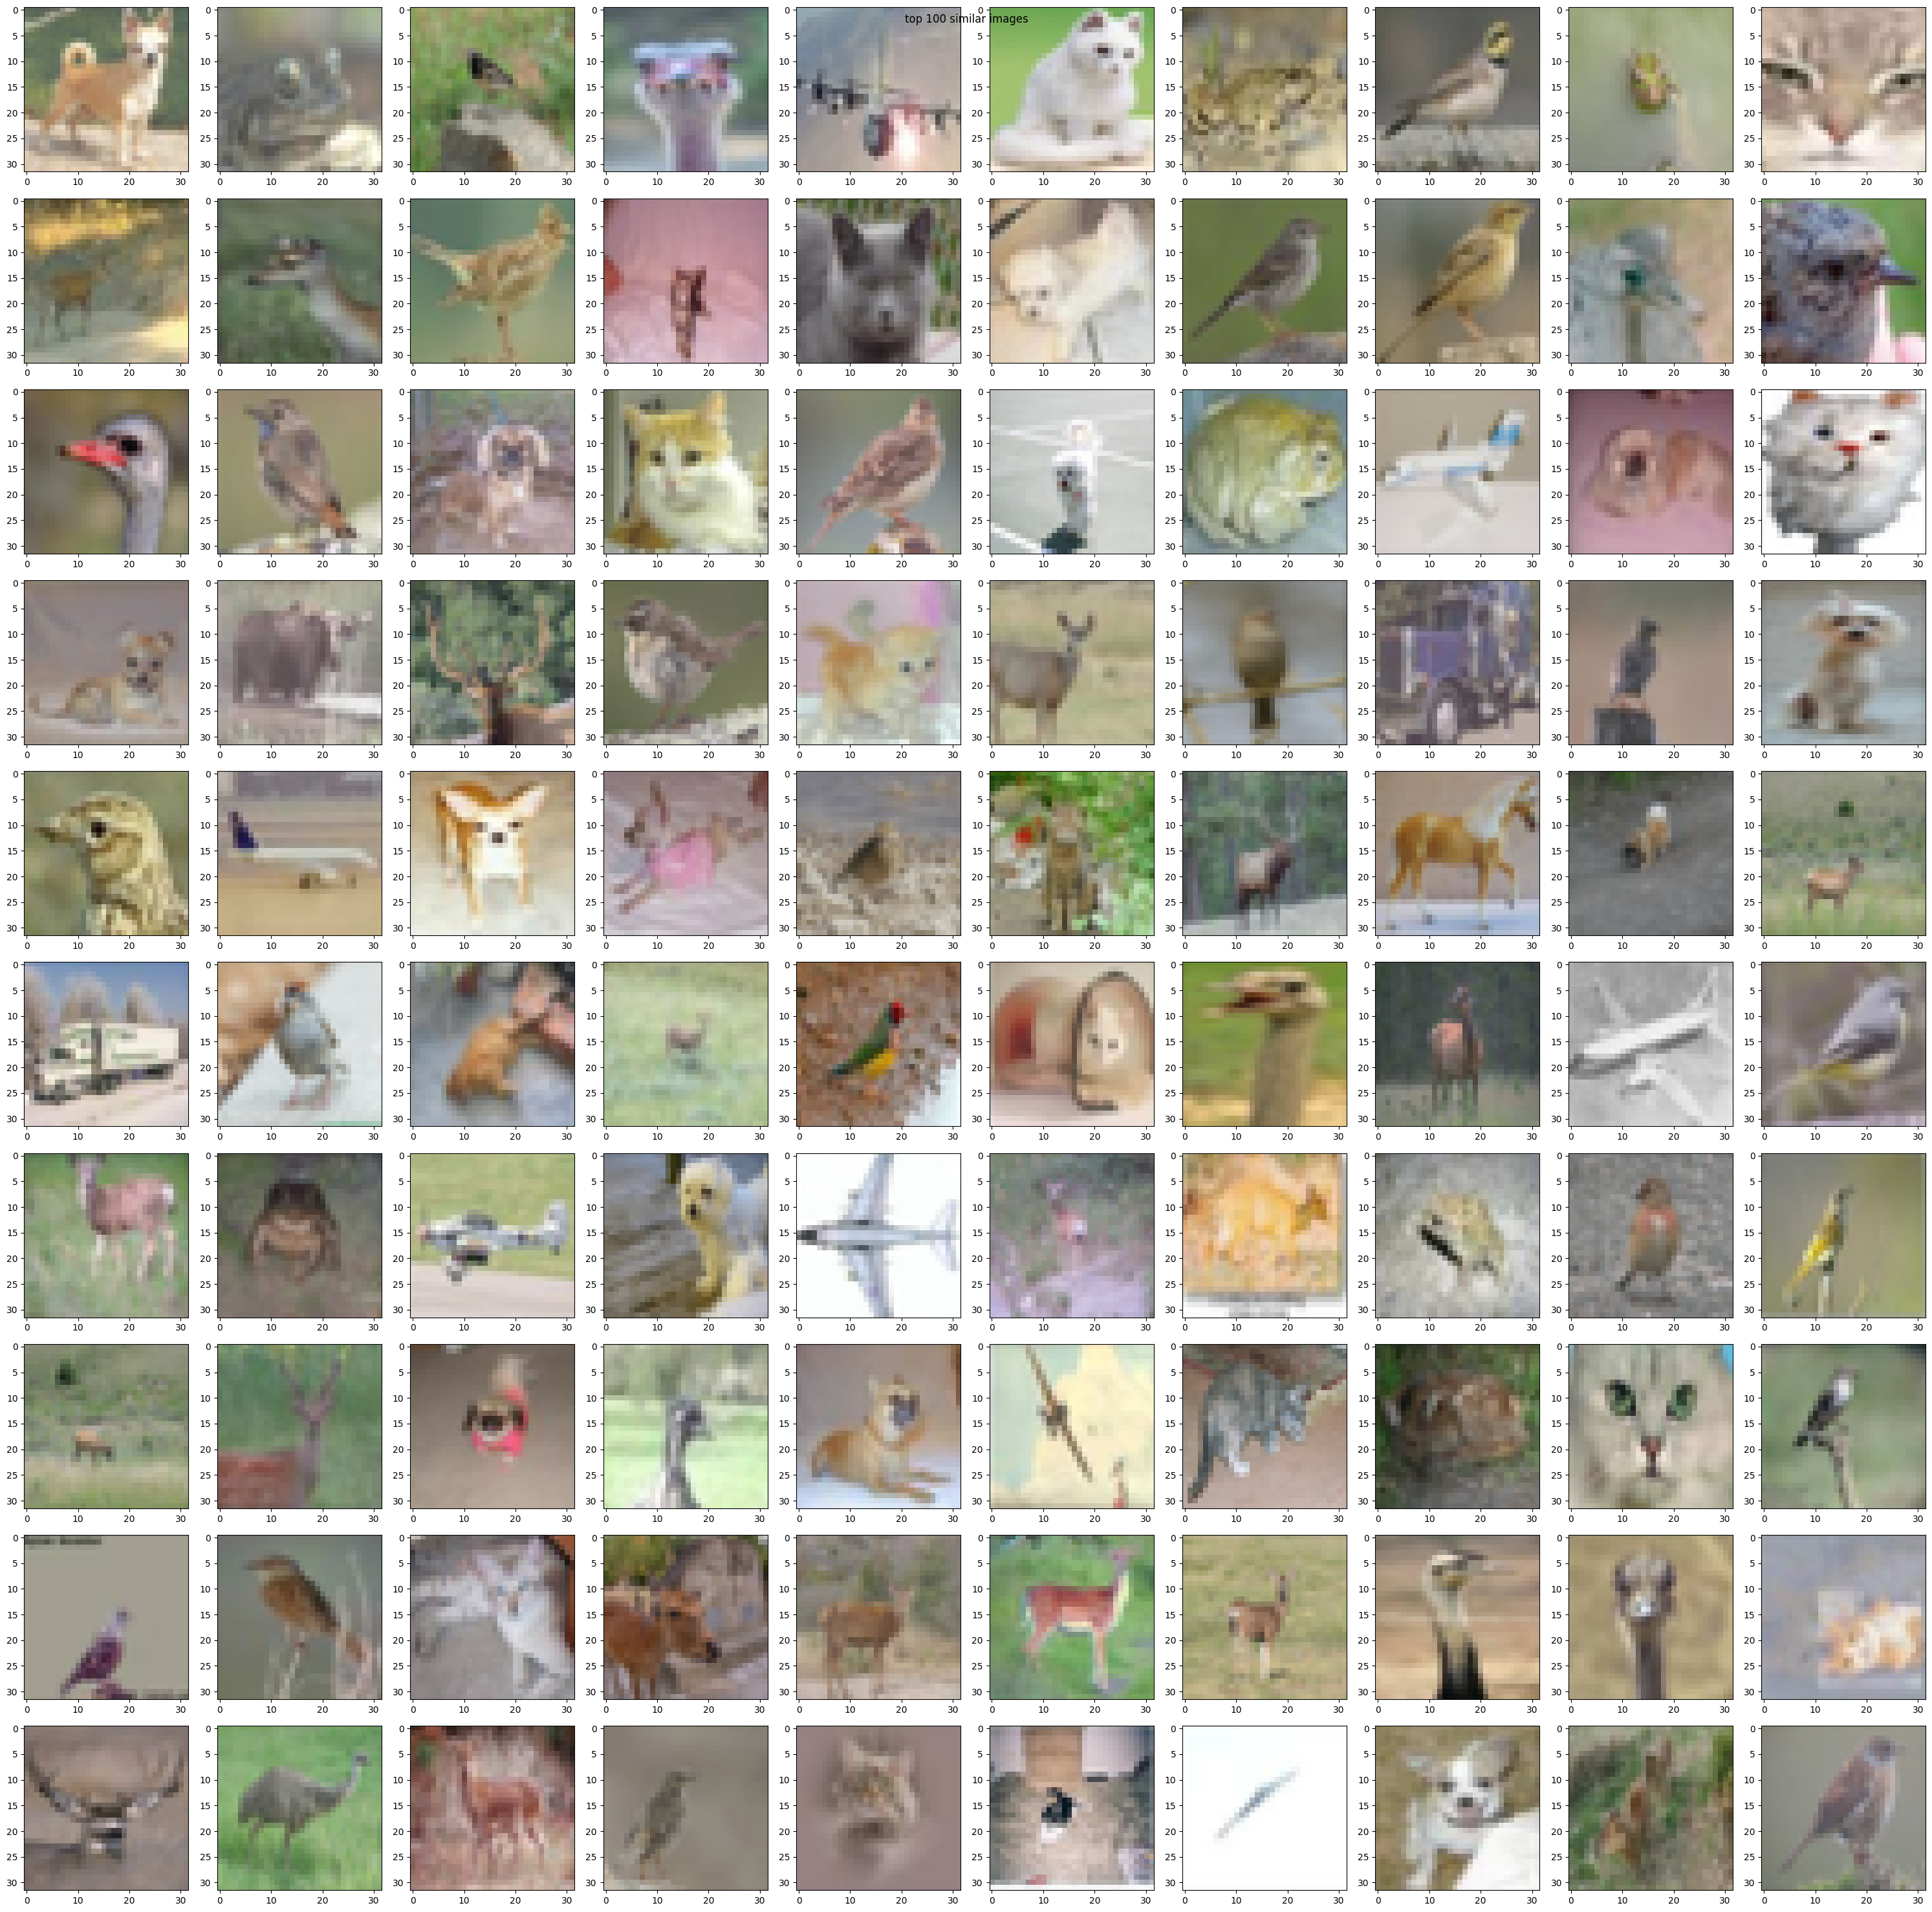

In [34]:
n = 1000
top_n_idx = similarity_indexed_sorted[0, -n:]
top_n_idx = top_n_idx[::-1]
top_n_img = {}

for i, data in enumerate(cifar10): 
    if i in top_n_idx:
        top_n_img[i] = data["img"]


fig, axs = plt.subplots(10, 10, figsize=(30, 30))

axs = axs.flatten()

for j in range(100):
    axs[j].imshow(np.moveaxis(transform(top_n_img[top_n_idx[j]]).numpy(), 0, -1))

fig.suptitle("top 100 similar images")

plt.tight_layout()

plt.savefig("generated_CIFAR10_train_top100.jpg", dpi=400)

In [118]:
n_decomp = 100

top_decomp = [top_n_img[j] for j in top_n_idx[:n_decomp]]

M_top = torch.stack([torch.flatten(transform(img)) * 2 - 1 for img in top_decomp])
svd_top = torch.svd(M_top)
# pca_top = torch.pca_lowrank(M_top, center=True)


# pca_top[2].shape
svd_top.V.t().shape

torch.Size([100, 3072])

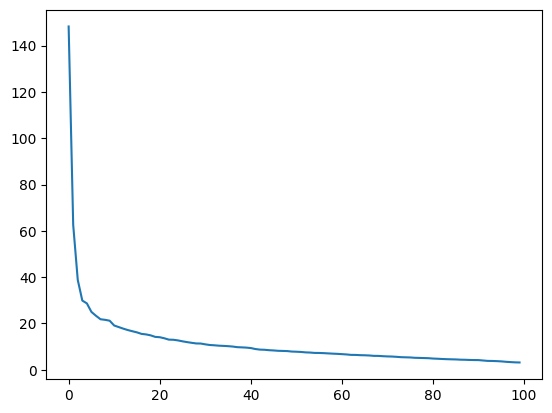

In [119]:
plt.plot(svd_top.S.numpy())

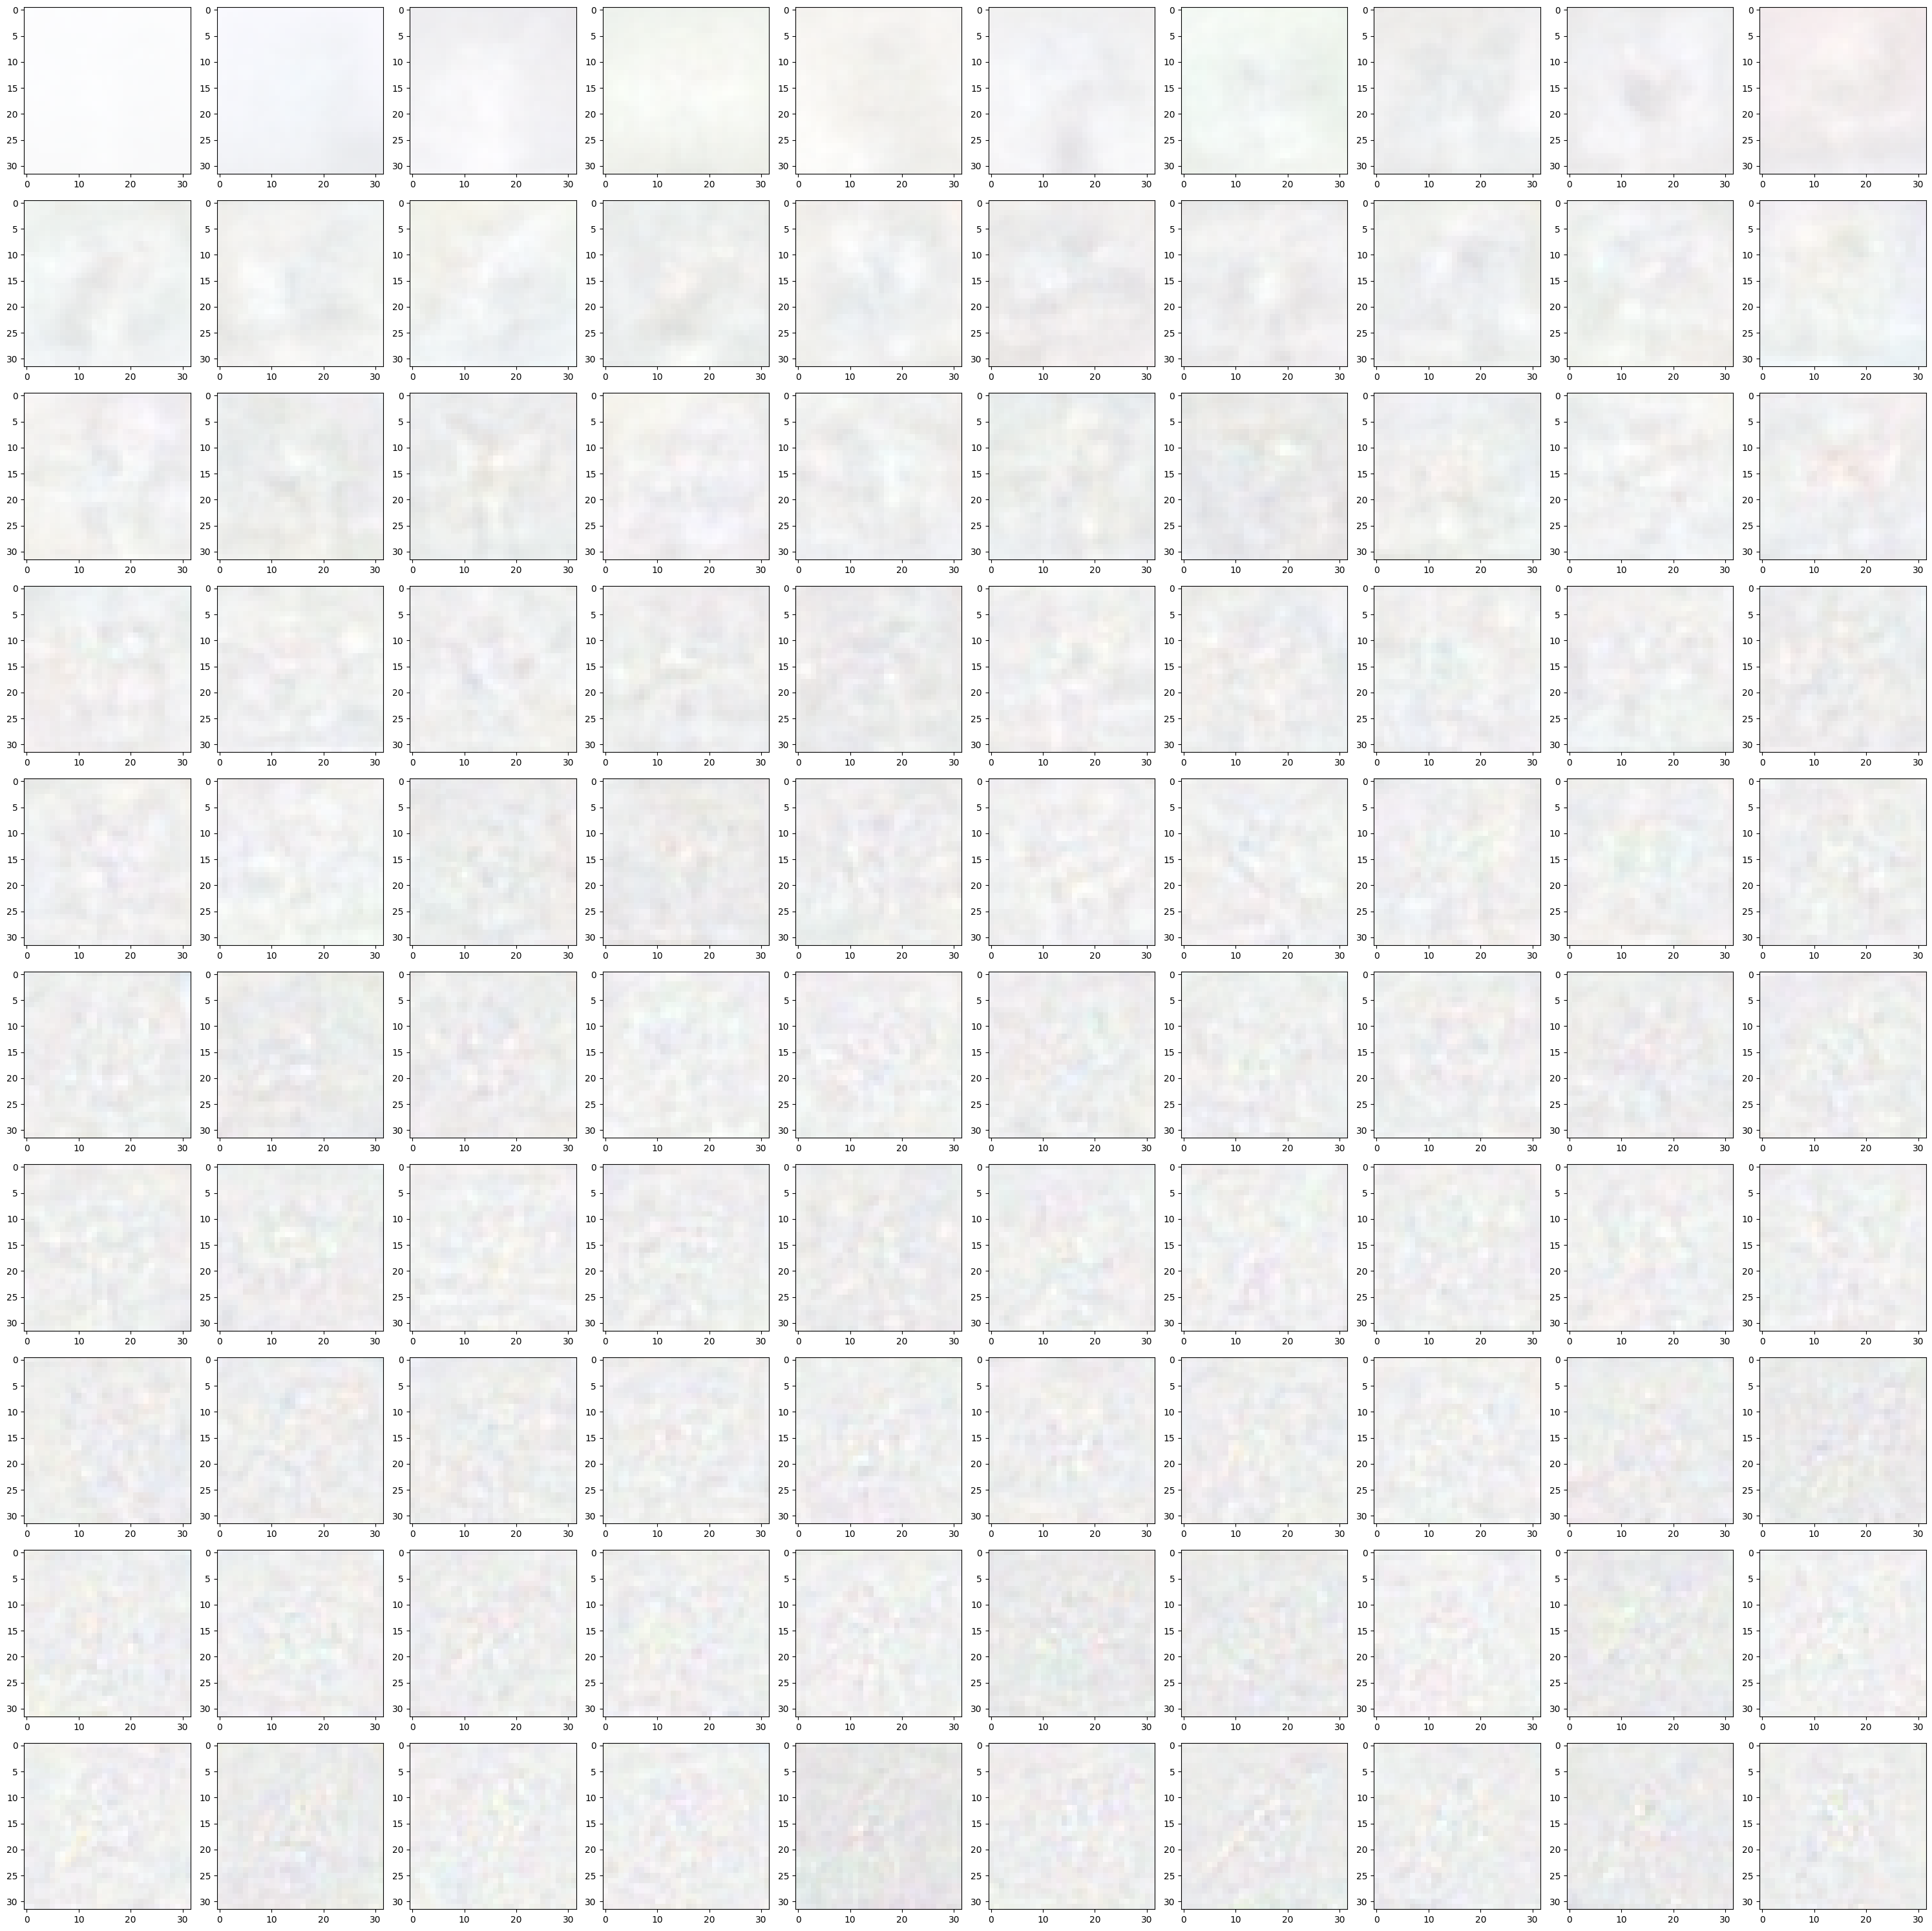

In [120]:
fig, axs = plt.subplots(10, 10, figsize=(30, 30))

n_top_sv = n_decomp

axs = axs.flatten()

for j in range(n_top_sv):
    sv_reshaped = svd_top.V.t()[j].reshape((3,32,32)) / 2 + 0.5
    # sv_reshaped = pca_top[2].t()[j].reshape((3,32,32)) / 2 + 0.5

    sv_reshaped /= torch.max(torch.abs(sv_reshaped))

    axs[j].imshow(
        np.moveaxis(sv_reshaped.numpy(), 0, -1)
    )

plt.tight_layout()
plt.savefig(f"closest_{n_decomp}_data.jpg", dpi=400)


In [121]:
svd_top.V.t().shape
torch.norm(svd_top.V.t(), dim=1)[None, :]

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000]])

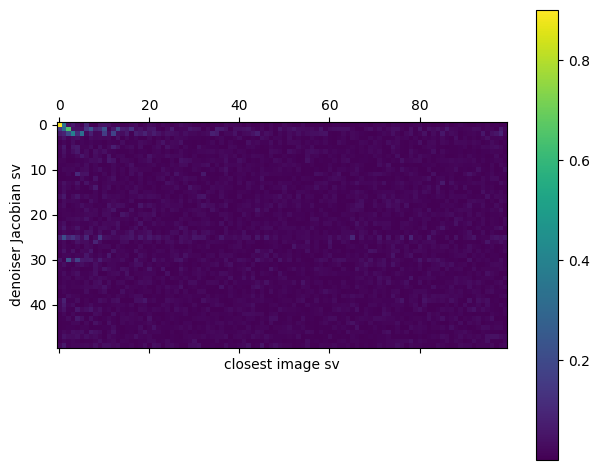

In [122]:
cos_sv = torch.abs(svd.V.t()[:50] @ svd_top.V.to(device))

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cos_sv.cpu(), interpolation='nearest')
fig.colorbar(cax)

ax.set_xlabel("closest image sv")
ax.set_ylabel("denoiser Jacobian sv")

plt.tight_layout()
plt.savefig(f"cos_Jac_data_t={t}.jpg", dpi=300)

## TODO: 
- cosine similarity of this svd with singular vectors of denoiser jacobian
- denoiser jacobian sv similarity to training images
- sv of closest data can be written as some of denoiser sv? i.e. project the singular vectors
- in general, how can we compare the two sets of singular vectors?
- in a model that completely memorizes: what do the singular vectors do?

## Loop through Jacobian computation



In [22]:
list(range(2, 50, 3))

[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47]

In [15]:
times = [1] + list(range(2, 50, 3)) + list(range(50, 1000, 50))

sv_out = {}

for t in times:
    image_noisy = add_noise(image, t)
    img_noisy_v = torch.reshape(image_noisy, (3072,)).to(device)

    def denoise_as_vector(x):
        x = torch.reshape(x, (1,3,32,32))
        pred = denoise(x, t, rescaled=False)
        print(t)
        return torch.reshape(pred, (3072,))

    J_trained = jacobian(denoise_as_vector, inputs=img_noisy_v)
    
    svd = torch.svd(J_trained)
    
    sv_sorted = sorted(svd.S.detach().cpu(), reverse=True)
    # sv_out.append(sv_sorted)
    sv_out[t] = sv_sorted

1
2
5
8
11
14
17
20
23
26
29
32
35
38
41
44
47
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


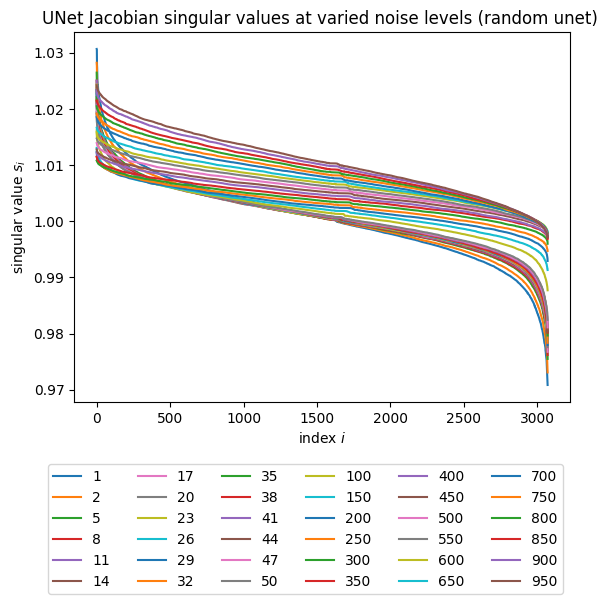

In [17]:
#for t in times[0::3]:
for t in times:

    # if t > 1: plt.plot(CURR_OUT[t], label=t)
    plt.plot(torch.tensor(sv_out[t]), label=t)
    # plt.plot(sv, label=t)
plt.title("UNet Jacobian singular values at varied noise levels (random unet) ")
plt.ylabel("singular value $s_i$")
plt.xlabel("index $i$")
plt.legend(bbox_to_anchor=(1, -0.15), ncols=6)

[1, 2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950]
[tensor(29.6123), tensor(32.8315), tensor(42.3610), tensor(44.2449), tensor(46.4620), tensor(45.3899), tensor(45.8334), tensor(46.8766), tensor(49.7394), tensor(49.6465), tensor(49.8605), tensor(48.2132), tensor(50.0173), tensor(50.8301), tensor(51.3355), tensor(51.9320), tensor(51.7988), tensor(51.3783), tensor(53.5124), tensor(54.2994), tensor(54.0814), tensor(54.4870), tensor(54.1571), tensor(54.4457), tensor(54.5635), tensor(54.5252), tensor(54.5830), tensor(54.6982), tensor(54.8420), tensor(54.8886), tensor(55.0075), tensor(55.0294), tensor(55.1557), tensor(55.3035), tensor(55.3603), tensor(55.3630)]


Text(0.5, 0, 'noise level')

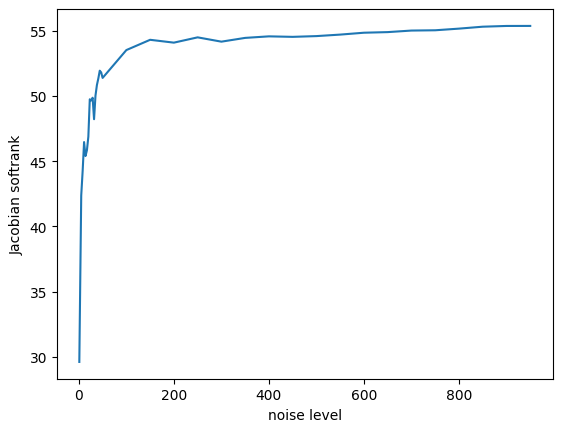

In [61]:
def softrank(sv):
    sv_sorted = sorted(sv, reverse=True)
    return torch.norm(torch.stack(sv_sorted)) / sv_sorted[0]

print(times)
softranks = [softrank(sv_out[t]) for t in times]
print(softranks)
plt.plot(times, softranks)
plt.ylabel("Jacobian softrank")
plt.xlabel("noise level")

Text(0.5, 0, 'noise level')

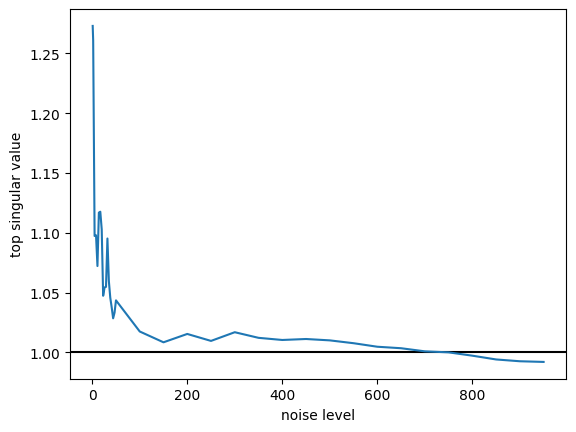

In [62]:
top = [sv_out[t][0] for t in times]
plt.axhline(1, color="black")
plt.plot(times, top)

plt.ylabel("top singular value")
plt.xlabel("noise level")

In [101]:
sv_cov = {}
J_trace = {}

for t in times:
    image_noisy, beta_t = add_noise(image, t, return_beta=True)
    img_noisy_v = torch.reshape(image_noisy, (3072,)).to(device)

    def evaluate_as_vector(x):
        x = torch.reshape(x, (1,3,32,32))
        out = ddpm.unet(x, t).sample
        print(t)
        return torch.reshape(out, (3072,))

    J_trained = jacobian(evaluate_as_vector, inputs=img_noisy_v)

    J_trace[t] = torch.trace(J_trained)

    J_trained *= beta_t
    
    svd = torch.svd(J_trained)
    sv_sorted = sorted(svd.S.detach().cpu(), reverse=True)
    # sv_out.append(sv_sorted)
    sv_cov[t] = sv_sorted

1
4
7
10
13
16
19
22
25
28
31
34
37
40
43
46
49
51
101
151
201
251
301
351
401
451
501
551
601
651
701
751
801
851
901
951


Text(0, 0.5, 'UNet Jacobians trace at different noise levels')

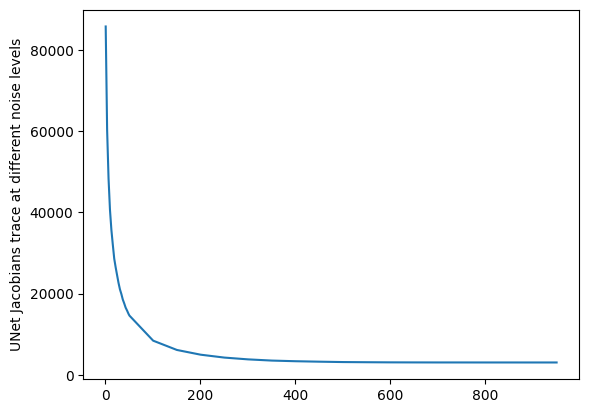

In [111]:
traces = [x.detach().cpu().numpy() for x in J_trace.values()]
plt.plot(times, traces)
plt.ylabel("trace")
plt.ylabel("noise level")
plt.ylabel("UNet Jacobians trace at different noise levels")

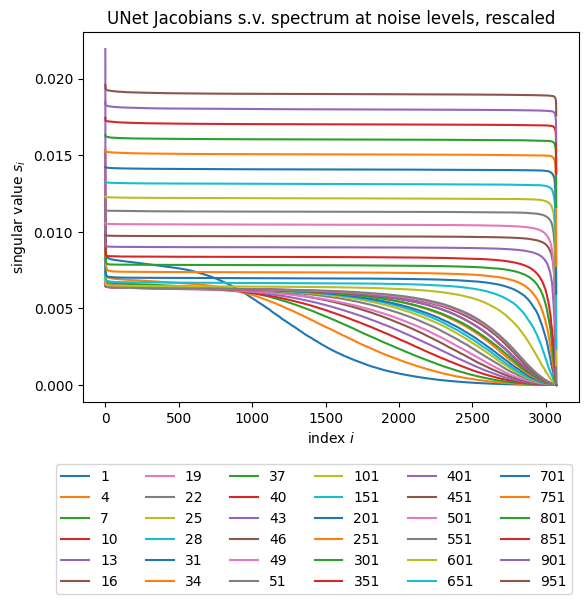

In [110]:
for t in times:
    # if t > 1: plt.plot(CURR_OUT[t], label=t)
    plt.plot(sv_cov[t], label=t)
    # plt.plot(sv, label=t)
plt.title("UNet Jacobians s.v. spectrum at noise levels, rescaled")
plt.ylabel("singular value $s_i$")
plt.xlabel("index $i$")
plt.legend(bbox_to_anchor=(1, -0.15), ncols=6)

[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 51, 101, 151, 201, 251, 301, 351, 401, 451, 501, 551, 601, 651, 701, 751, 801, 851, 901, 951]
[tensor(26.3439), tensor(28.4999), tensor(34.0330), tensor(37.9462), tensor(39.6209), tensor(41.4002), tensor(42.2604), tensor(43.2268), tensor(44.2478), tensor(44.9803), tensor(44.8081), tensor(45.8871), tensor(45.5847), tensor(46.0010), tensor(46.7613), tensor(47.0682), tensor(46.7939), tensor(47.9819), tensor(48.5025), tensor(42.4016), tensor(37.3224), tensor(42.4143), tensor(35.2876), tensor(29.6091), tensor(22.5192), tensor(54.6764), tensor(54.5977), tensor(54.8429), tensor(54.7854), tensor(54.7811), tensor(54.7997), tensor(54.3470), tensor(54.3773), tensor(54.1189), tensor(53.9428), tensor(53.7488)]


Text(0.5, 0, 'noise level')

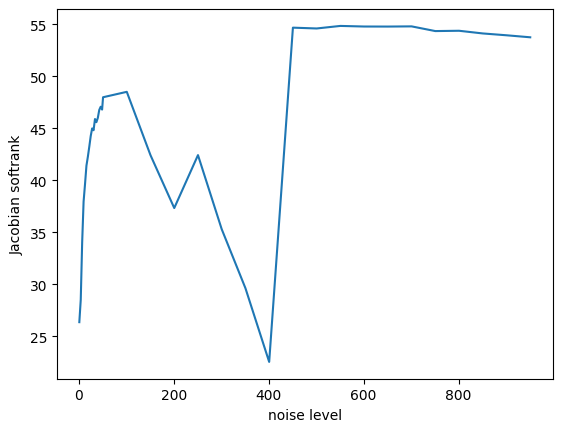

In [109]:
print(times)
softranks_cov = [softrank(sv_cov[t]) for t in times]
print(softranks_cov)
plt.plot(times, softranks_cov)
plt.ylabel("Jacobian softrank")
plt.xlabel("noise level")

## Generation

In [17]:
def get_noise():
    return torch.randn((1,3,32,32)).to(device)

x_prev = get_noise()

ddpm.unet.eval()

for t in reversed(range(1000)):
    if t > 0:
        noise = get_noise()
    else:
        noise = torch.zeros((1, 3,32,32)).to(device)

    clip_image_coeff = 1 / torch.sqrt(alphas_prod[t])
    clip_noise_coeff = torch.sqrt(1 / alphas_prod[t] - 1)
    
    image_coeff = (1 - alphas_prod[t-1]) * torch.sqrt(alphas[t]) / (1 - alphas_prod[t])
    clipe_coeff = torch.sqrt(alphas_prod[t-1]) * betas[t] / (1 - alphas_prod[t])
    

    # noise_scale = (1 - alphas[t]) / torch.sqrt(1 - alphas_prod[t]) 
    
    with torch.no_grad():
        noise_pred = ddpm.unet(x_prev, t).sample

    pred_mean = clip_image_coeff * image - clip_noise_coeff * noise_pred
    pred_mean = torch.clip(pred_mean, -1, 1)
        
    prev_image = clip_coeff * pred_mean + image_coeff * image

    x_new = (1 / torch.sqrt(alphas[t]) ) * (x_prev - noise_scale * noise_pred) + torch.sqrt(betas[t]) * z

    x_prev = x_new

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-197.58263..207.33498].


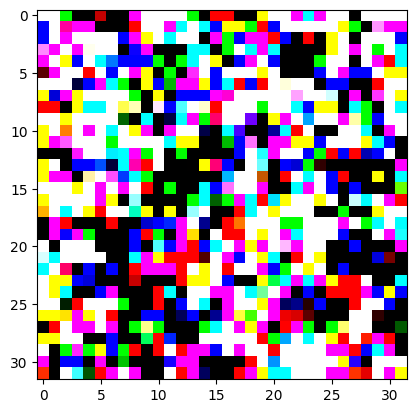

In [18]:
plt.imshow(np.moveaxis((x_new[0] / 2 + 0.5).detach().cpu().numpy(), 0, -1))